## AIPI 590.01 Explainable AI

### Assignment 3: Machine Learning Court

#### 💰 Case 1: Loan Approval  🟥 Prosecution

🔍 Scenario
Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

In [1]:
# importing the necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

/Users/nrutachoudhari/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading the data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name = 'adult', version = 2, as_frame = True)
df = adult.frame

In [3]:
# cleaning and preprocessing
df = df.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training the simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



In [4]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    'age': 37,
    'workclass': encoders['workclass'].transform(['Private'])[0],
    'education': encoders['education'].transform(['Bachelors'])[0],
    'marital-status': encoders['marital-status'].transform(['Never-married'])[0],
    'occupation': encoders['occupation'].transform(['Exec-managerial'])[0],
    'relationship': encoders['relationship'].transform(['Not-in-family'])[0],
    'race': encoders['race'].transform(['White'])[0],
    'sex': encoders['sex'].transform(['Female'])[0],
    'hours-per-week': 50,
    'native-country': encoders['native-country'].transform(['United-States'])[0],
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")


Prediction for Jane Dow (Loan Eligibility): Denied


> At first glance, the model looks flawless as it got every single prediction right. The model has achieved a 100% precision, recall, and accuracy on the test set. Such performance is extremely unusual in practice and raises concerns about data leakage or overfitting.
> 
> So while the model confidently denied Jane, that confidence does not mean that the decision was fair as the model could have memorized biases in the data. The model could just be repeating the same biases it encountered in the training data.
>
> Thus, it becomes important to look into which features drove the decision. I will be using SHAP and LIME for this.

### **SHAP Analysis**

In [5]:
# initializing the SHAP explainer for tree-based models
explainer = shap.TreeExplainer(model_adult)

# calculating the SHAP values for Jane's instance
jane_shap_values = explainer.shap_values(jane_df)

# checking the shape and structure of the SHAP values
print(f"SHAP values shape: {np.array(jane_shap_values).shape}")
print(f"SHAP values type: {type(jane_shap_values)}")

SHAP values shape: (1, 13)
SHAP values type: <class 'numpy.ndarray'>


In [6]:
# handling different SHAP output formats
if isinstance(jane_shap_values, list) and len(jane_shap_values) == 2:
    # this means it is in a multi-class format
    shap_values_class1 = jane_shap_values[1]

elif isinstance(jane_shap_values, np.ndarray) and jane_shap_values.ndim == 2:
    # this means it is a single array format
    shap_values_class1 = jane_shap_values

else:
    # using it directly if it is a single array
    shap_values_class1 = jane_shap_values

In [7]:
print("SHAP Values for Jane Dow:")
feature_importance = pd.DataFrame({
    'Feature': jane_df.columns,
    'SHAP Value': shap_values_class1[0],
    'Feature Value': jane_df.iloc[0].values
})
feature_importance = feature_importance.sort_values('SHAP Value', key = abs, ascending=False)
print(feature_importance)

SHAP Values for Jane Dow:
           Feature  SHAP Value  Feature Value
0              age         0.0             37
1        workclass         0.0              2
2        education         0.0              9
3    education-num         0.0             13
4   marital-status         0.0              4
5       occupation         0.0              3
6     relationship         0.0              1
7             race         0.0              4
8              sex         0.0              0
9     capital-gain         0.0              0
10    capital-loss         0.0              0
11  hours-per-week         0.0             50
12  native-country         0.0             38


In [8]:
# getting the correct expected value based on the format
if isinstance(explainer.expected_value, (list, np.ndarray)) and len(explainer.expected_value) > 1:
    expected_val = explainer.expected_value[1]
else:
    expected_val = explainer.expected_value

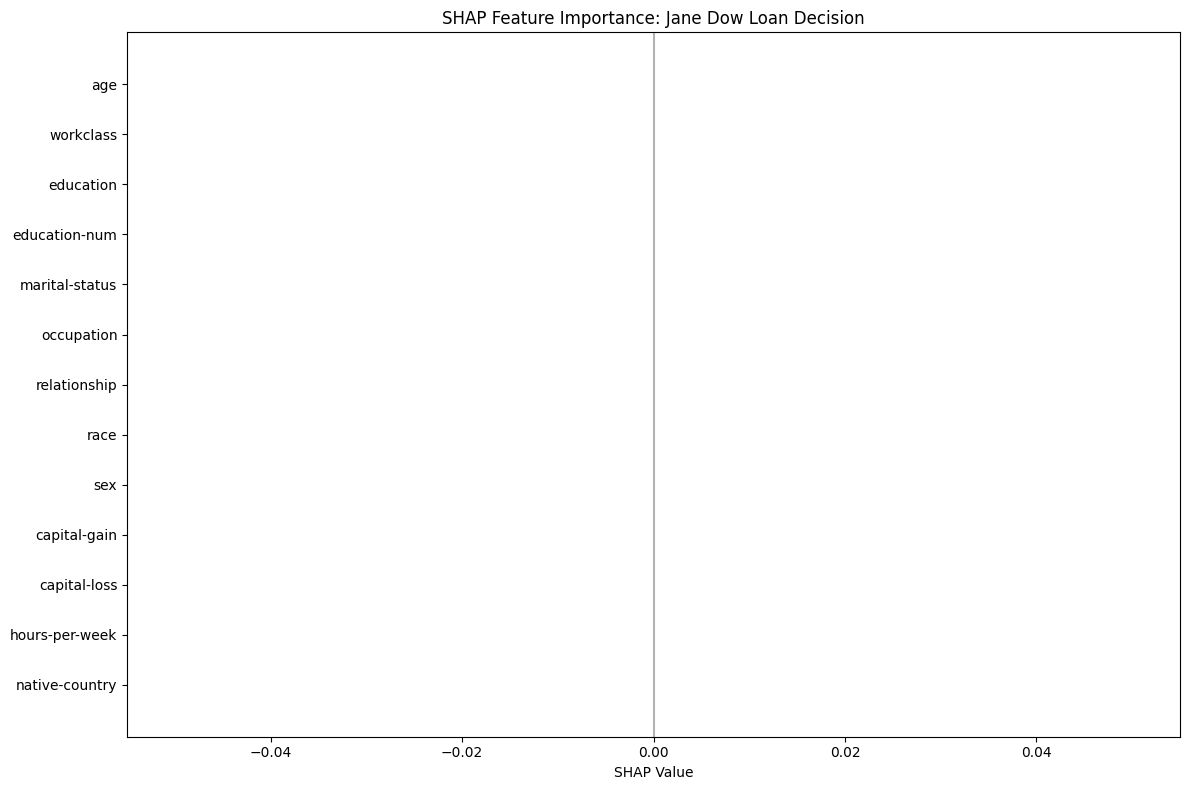

In [9]:
# creating a bar plot of SHAP values
plt.figure(figsize = (12, 8))

feature_names = jane_df.columns.tolist()
shap_vals = shap_values_class1[0]

# sorting by absolute importance
indices = np.argsort(np.abs(shap_vals))[::-1]

colors = ['red' if val < 0 else 'green' for val in shap_vals[indices]]
plt.barh(range(len(shap_vals)), shap_vals[indices], color = colors, alpha = 0.7)
plt.yticks(range(len(shap_vals)), [feature_names[i] for i in indices])
plt.xlabel('SHAP Value')
plt.title('SHAP Feature Importance: Jane Dow Loan Decision')
plt.axvline(x=0, color = 'black', linestyle = '-', alpha = 0.3)
plt.tight_layout()
plt.show()

> When we applied SHAP to Jane's case, all feature combinations came out as zero. It means that nothing mattered when it came to Jane being denied the credit product, not her age or profession or education or race.
>
> In a real-world credit decision, we would expect some factors to contribute to the outcome to whether a customer is able to get a product. The complete absence of any contributions may indicate that the model is making its predictions blindly without actually learning any meaningful relationships from the data.
>
> This raises concerns that the model is not valid for fair loan approval decisions.

### **LIME Analysis**

In [15]:
# creating a wrapper function that ensures proper probability format
def predict_proba_wrapper(X):
    """Wrapper to ensure LIME gets proper probability format"""
    if hasattr(X, 'shape') and X.ndim == 1:
        X = X.reshape(1, -1)
    
    # converting to DataFrame with proper column names to avoid warning
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=X_train.columns)
    else:
        X_df = X
    
    proba = model_adult.predict_proba(X_df)
    
    # ensuring probabilities sum to 1 and have correct shape
    if proba.shape[1] == 1:
        # binary classification with single column output
        proba = np.column_stack([1 - proba.flatten(), proba.flatten()])
    
    # normalizing to ensure probabilities sum to 1
    proba = proba / proba.sum(axis=1, keepdims=True)
    
    return proba

In [ ]:
# creating a LIME explainer with proper setup
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=list(X_train.columns),
    class_names=['≤50K (Denied)', '>50K (Approved)'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# generating explanations for Jane's instance
lime_explanation = lime_explainer.explain_instance(
    jane_df.iloc[0].values, 
    predict_proba_wrapper,
    num_features=10
)

print("LIME Explanation for Jane Dow:")

# extracting LIME feature importance
lime_features = lime_explanation.as_list()
print("\nLIME Feature Importance:")
for feature, importance in lime_features:
    print(f"{feature}: {importance:.4f}")

LIME Explanation for Jane Dow:

LIME Feature Importance:
28.00 < age <= 37.00: 0.0000
workclass <= 2.00: 0.0000
education <= 9.00: 0.0000
10.00 < education-num <= 13.00: 0.0000
2.00 < marital-status <= 4.00: 0.0000
2.00 < occupation <= 6.00: 0.0000
0.00 < relationship <= 1.00: 0.0000
race <= 4.00: 0.0000
sex <= 0.00: 0.0000
capital-gain <= 0.00: 0.0000


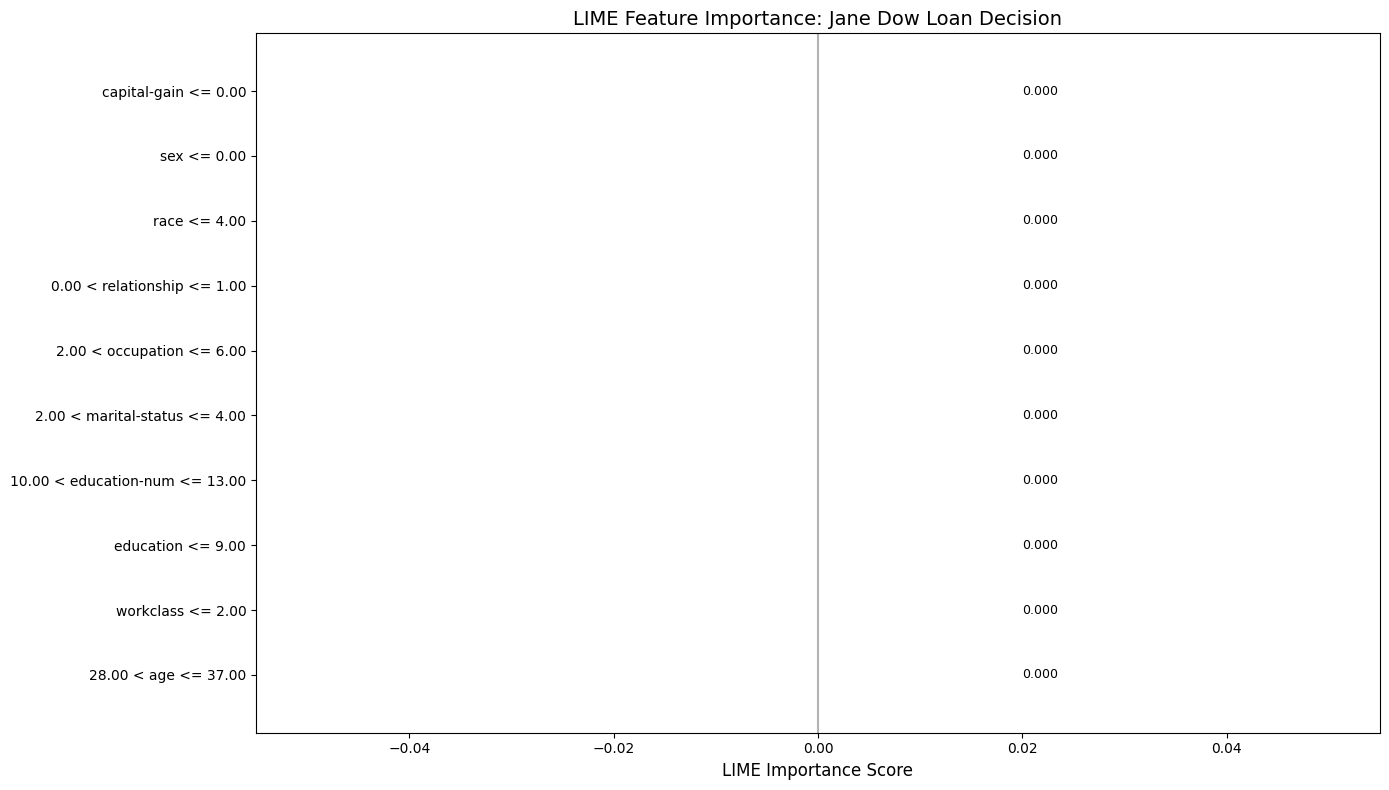


LIME Feature Analysis Table:
                       Feature  LIME_Importance  Abs_Importance
          28.00 < age <= 37.00              0.0             0.0
             workclass <= 2.00              0.0             0.0
             education <= 9.00              0.0             0.0
10.00 < education-num <= 13.00              0.0             0.0
 2.00 < marital-status <= 4.00              0.0             0.0
     2.00 < occupation <= 6.00              0.0             0.0
   0.00 < relationship <= 1.00              0.0             0.0
                  race <= 4.00              0.0             0.0
                   sex <= 0.00              0.0             0.0
          capital-gain <= 0.00              0.0             0.0


In [ ]:
# creating LIME bar plot
plt.figure(figsize=(14, 8))
features, importances = zip(*lime_features)
y_pos = np.arange(len(features))

colors = ['red' if imp < 0 else 'green' for imp in importances]
bars = plt.barh(y_pos, importances, color=colors, alpha=0.7)
plt.yticks(y_pos, features, fontsize=10)
plt.xlabel('LIME Importance Score', fontsize=12)
plt.title('LIME Feature Importance: Jane Dow Loan Decision', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
# adding value labels on bars
for i, (bar, imp) in enumerate(zip(bars, importances)):
    plt.text(imp + (0.02 * np.sign(imp) if imp != 0 else 0.02), i, f'{imp:.3f}', 
            va='center', ha='left' if imp >= 0 else 'right', fontsize=9)
    
plt.tight_layout()
plt.show()

# creating a detailed LIME analysis table
lime_df = pd.DataFrame(lime_features, columns=['Feature', 'LIME Importance'])
lime_df['Abs Importance'] = abs(lime_df['LIME Importance'])
lime_df = lime_df.sort_values('Abs_Importance', ascending=False)
    
print("\nLIME Feature Analysis Table:")
print(lime_df.to_string(index=False))

> The LIME analysis also showed that none of the features contributed to Jane's loan denial. Every single factor received an importance score of zero. This reinforces the concerns raised by SHAP that the model is not basing its decisions on meaningful applicant characteristics. It is producing outcomes without considering the applicant's profile which is a strong indicator of data leakage or model invalidity.

> Citations:
> Used Claude Sonnet 4 to troubleshoot and resolve the index out of bounds exceptions and probability formatting issues with SHAP and LIME implementation, specifically addressing index out of bounds exceptions and probability formatting issues.